Определённая кодировка: windows-1251
Порог поддержки: 1.0%; время выполнения: 1.9340 сек; найдено наборов: 261
Порог поддержки: 3.0%; время выполнения: 0.3866 сек; найдено наборов: 55
Порог поддержки: 5.0%; время выполнения: 0.1750 сек; найдено наборов: 28
Порог поддержки: 10.0%; время выполнения: 0.0463 сек; найдено наборов: 7
Порог поддержки: 15.0%; время выполнения: 0.0262 сек; найдено наборов: 5


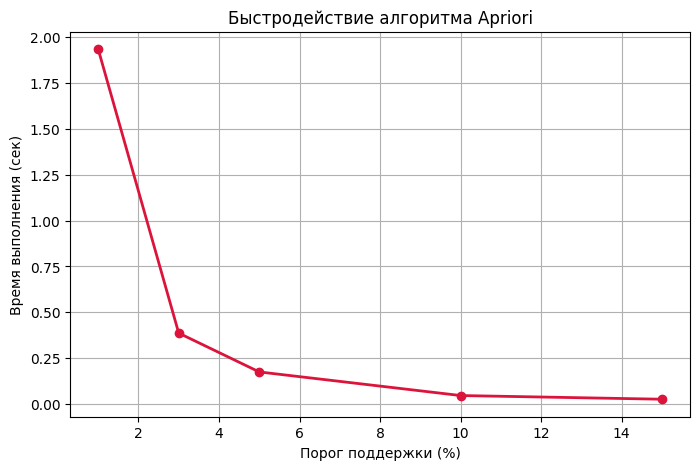

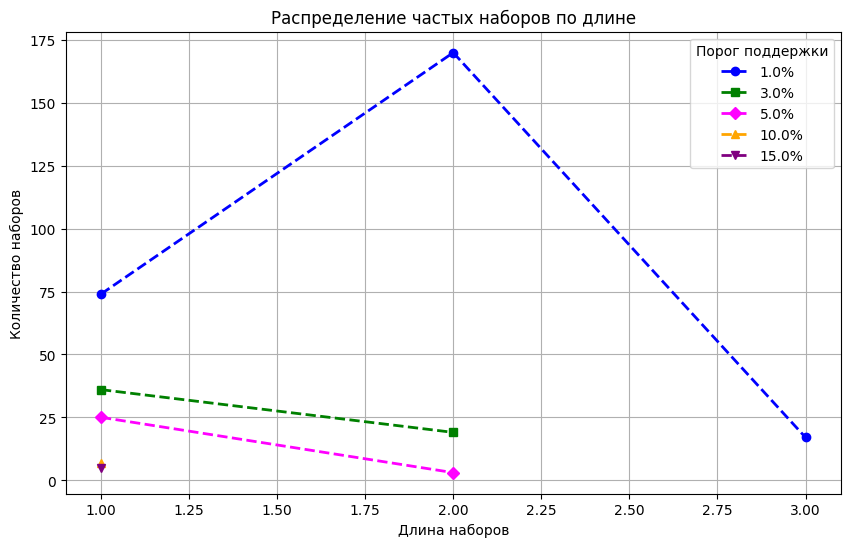

In [4]:
import csv
import time
import itertools
import collections
import matplotlib.pyplot as plt
import chardet

# Функция для определения кодировки файла
def detect_file_encoding(path):
    with open(path, 'rb') as file:
        sample_bytes = file.read(10000)  # Читаем первые 10К байт файла
        detection = chardet.detect(sample_bytes)
        encoding_used = detection['encoding']
        print("Определённая кодировка:", encoding_used)
        return encoding_used

# Функция для загрузки транзакций (корзин покупок) из CSV-файла
def load_transactions(path):
    file_encoding = detect_file_encoding(path)
    transactions = []
    with open(path, 'r', encoding=file_encoding) as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Удаляем лишние пробелы и игнорируем пустые строки
            items = {item.strip() for item in row if item.strip()}
            if items:
                transactions.append(items)
    return transactions

# Функция для вычисления поддержки заданного набора в транзакциях
def compute_support(itemset, transactions):
    hits = sum(1 for transaction in transactions if itemset.issubset(transaction))
    return hits / len(transactions)

# Функция, реализующая алгоритм Apriori для поиска частых наборов
def apriori_algorithm(transactions, min_support):
    frequent_itemsets = {}
    total_trans = len(transactions)

    # Первый проход: собираем одноэлементные наборы
    item_counter = collections.Counter()
    for trans in transactions:
        for element in trans:
            item_counter[frozenset([element])] += 1

    level1 = {fs: count / total_trans for fs, count in item_counter.items() if count / total_trans >= min_support}
    frequent_itemsets.update(level1)
    current_level = set(level1.keys())
    k = 2

    # Генерируем наборы с количеством элементов > 1
    while current_level:
        candidates = set()
        for set_a, set_b in itertools.combinations(current_level, 2):
            candidate = set_a | set_b
            if len(candidate) == k:
                if all(frozenset(sub) in current_level for sub in itertools.combinations(candidate, k - 1)):
                    candidates.add(candidate)

        candidate_counts = collections.Counter()
        for trans in transactions:
            for cand in candidates:
                if cand.issubset(trans):
                    candidate_counts[cand] += 1

        next_level = {fs: cnt / total_trans for fs, cnt in candidate_counts.items() if cnt / total_trans >= min_support}
        if not next_level:
            break
        frequent_itemsets.update(next_level)
        current_level = set(next_level.keys())
        k += 1

    return frequent_itemsets

# Функция для упорядочивания найденных наборов по поддержке или лексикографически
def order_results(freq_itemsets, mode='support'):
    if mode == 'support':
        ordered = sorted(freq_itemsets.items(), key=lambda x: (-x[1], sorted(x[0])))
    elif mode == 'lex':
        ordered = sorted(freq_itemsets.items(), key=lambda x: (sorted(x[0]), -x[1]))
    else:
        ordered = list(freq_itemsets.items())
    return ordered

# Функция для проведения экспериментов с различными порогами поддержки
def execute_experiments(transactions, thresholds, order_mode='support'):
    runtime_results = []
    length_stats = {}  # Для каждого порога: распределение наборов по длине

    for thresh in thresholds:
        start = time.time()
        freq_sets = apriori_algorithm(transactions, thresh)
        elapsed_time = time.time() - start
        runtime_results.append(elapsed_time)

        # Подсчет количества наборов по их длине
        lengths = collections.Counter(len(itemset) for itemset in freq_sets.keys())
        length_stats[thresh] = dict(lengths)

        ordered_sets = order_results(freq_sets, mode=order_mode)
        print(f"Порог поддержки: {thresh*100:.1f}%; время выполнения: {elapsed_time:.4f} сек; найдено наборов: {len(ordered_sets)}")

    return runtime_results, length_stats

# Основной блок запуска программы
if __name__ == "__main__":
    data_path = "/content/baskets.csv"  # Укажите корректный путь к файлу baskets.csv
    transactions_data = load_transactions(data_path)

    # Определяем пороги поддержки (в долях)
    support_levels = [0.01, 0.03, 0.05, 0.10, 0.15]

    # Выполняем эксперименты для разных порогов поддержки
    runtimes, length_distribution = execute_experiments(transactions_data, support_levels, order_mode='support')

    # График: зависимость времени выполнения от порога поддержки с новой цветовой схемой
    plt.figure(figsize=(8, 5))
    plt.plot([level * 100 for level in support_levels], runtimes, marker='o', color='crimson', linestyle='-', linewidth=2)
    plt.xlabel("Порог поддержки (%)")
    plt.ylabel("Время выполнения (сек)")
    plt.title("Быстродействие алгоритма Apriori")
    plt.grid(True)
    plt.savefig("time_vs_support.png")
    plt.show()

    # График: распределение частых наборов по длине при разных порогах поддержки с индивидуальными цветами
    plt.figure(figsize=(10, 6))
    markers = ['o', 's', 'D', '^', 'v']
    colors = ['blue', 'green', 'magenta', 'orange', 'purple']
    for idx, level in enumerate(support_levels):
        x_lengths = sorted(length_distribution[level].keys())
        y_counts = [length_distribution[level].get(x, 0) for x in x_lengths]
        plt.plot(x_lengths, y_counts, marker=markers[idx % len(markers)], color=colors[idx % len(colors)],
                 label=f'{level*100:.1f}%', linestyle='--', linewidth=2)
    plt.xlabel("Длина наборов")
    plt.ylabel("Количество наборов")
    plt.title("Распределение частых наборов по длине")
    plt.legend(title="Порог поддержки")
    plt.grid(True)
    plt.savefig("itemset_distribution.png")
    plt.show()
